# Adagio, by J. Blasiok (Harvard) and C.E. Tsourakakis (BU, Harvard)

In the following, we present our method ADAGIO which produces data-aware near-isometric linear embeddings, much faster than its state-of-the-art competitor [Numax][1]. Our [work][2] was accepted for publication in the [IEEE Data MiningCDM 2016][3]. They key idea (see Theorem 2 for the technical details) of ADAGIO is to combine PCA with random projections to produce data-aware near-isometric linear embeddings. While the method due to [Numax][1] produces high-quality isometries, it is typically very slow on even medium scale datasets. We measure the quality of an isometry  by  computing for every pair the distortion caused by the linear embedding $\Pi$ as follows:

$$\left\{\left|\frac{\|\Pi x - \Pi y\|}{\|x - y\|} -1 \right| : x, y \in \text{cloud of points}\right\}$$


In the following we provide an implementation of ADAGIO, and show few applications.

[1]: http://people.csail.mit.edu/chinmay/files/papers/sdp_jmlr_submit.pdf
[2]: http://people.seas.harvard.edu/~babis/adagio.pdf 
[3]: http://icdm2016.eurecat.org/ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import DimensionalityReduction as dr
from itertools import count
import random
import math
import sys
import scipy as sp
import sklearn
import os
import scipy.io
from importlib import reload
%matplotlib inline

# Stable Rank

In our paper, we use stable rank to understand whether PCA may succeed in producing a high-quality near isometry. Let $\sigma_1\geq \ldots \geq \sigma_n$ be the singular values of a matrix A. We have observed empirically that whether a $k$-rank approximation produces (or not) a near-isometry depends on how large (or not)  fraction of the spectrum the top $k$ singular values capture. 

For each dataset, we compute its stable rank, defined as

$$r := \frac{(\sum \sigma_i)^2}{\sum \sigma_i^2}.$$

Stable rank is widely used as a method for evaluating the _intrisic_ dimensionality of the data (it is stable under some small distortions, and is always smaller than the ambient dimension).  On top of that, we compute what fraction of the spectrum energy is in all remaining eigenvalues, namely we calculate

$$\gamma := \frac{\sum_{i=\lfloor r \rfloor + 1} \sigma_i^2}{\sum \sigma_i^2}$$

Overall, we conjecture that padding PCA with extra dimensions will be especially significant for the datasets where this value is large.

In [2]:
def evaluate_data(data):
    (_, S, _) = np.linalg.svd(data)
    b = S.sum()
    SS = S*S
    stable_rank = (b*b) / (SS).sum()
    target_dimension = int(stable_rank)
    fraction_of_mass_left = SS[target_dimension+1:].sum() / SS.sum()
    return (stable_rank, fraction_of_mass_left, S) 

In our current path, there exists a folder named TimeSeries. In the following, we use ADAGIO as a dimensionality reduction technique for evaluating  1-NN classification of time series data. For evaluation we use the following the base of datasets [UCR Time Series Classification Archive][1]. 

[1]: http://www.cs.ucr.edu/~eamonn/time_series_data/

In [3]:
# make sure you give the right path in your machine, some sample datasets come in the github
def load_UCR(name):
    train = np.loadtxt("./TimeSeries/" + name + "/" +name + "_TRAIN", delimiter=',')
    test = np.loadtxt("./TimeSeries/" + name + "/" +name +  "_TEST", delimiter=',')
    train_labels = train[:,0].astype(np.int32)
    test_labels = test[:,0].astype(np.int32)
    train_data = train[:, 1:]
    test_data = test[:, 1:]
    
    train_avg = train_data.sum(axis=0).reshape((1, train_data.shape[1])) / train_data.shape[0]
    train_shift = train_avg.repeat(train_data.shape[0], axis=0)
    train_data = train_data - train_shift
    test_shift = train_avg.repeat(test_data.shape[0], axis=0)
    test_shift = test_data - test_shift
    return {'train_labels': train_labels, 'test_labels': test_labels, 'train_data': train_data, 'test_data': test_data}

In [4]:
import os
all_datasets = os.listdir('./TimeSeries')
#These are the folders that come with github, you can download more
for datasets in all_datasets:
        print(datasets)
# that is how the data looks like
load_UCR("Computers")

Computers
Earthquakes
FordB
LargeKitchenAppliances
Phoneme
RefrigerationDevices
ScreenType
SmallKitchenAppliances
SwedishLeaf
UWaveGestureLibraryAll


{'test_data': array([[-0.61464, -0.61464, -0.61464, ..., -0.61464, -0.61464, -0.61464],
        [-0.30611, -0.30611, -0.30611, ..., -0.30611, -0.30611, -0.20634],
        [ 1.4364 ,  1.4364 ,  1.4364 , ..., -0.72557, -0.72557, -0.67643],
        ..., 
        [-0.37083, -0.37083, -0.37083, ..., -0.37083, -0.37083, -0.37083],
        [ 1.6489 ,  1.1754 ,  1.6489 , ..., -0.71858, -0.71858, -0.71858],
        [-0.43168, -0.43168, -0.43168, ...,  1.9    ,  1.9    ,  1.9    ]]),
 'test_labels': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [5]:
counter  = 0
points = []
for dataset_name in all_datasets:
    print("Doing ", dataset_name)
    dataset = load_UCR(dataset_name)
    (rank, leftover, _) = evaluate_data(dataset['train_data'])
    points.append( (rank, leftover, dataset_name))
    counter = counter + 1
    print("Done ", dataset_name, " ", counter, " out of ", len(all_datasets))
    print("=====")

Doing  Computers
Done  Computers   1  out of  10
=====
Doing  Earthquakes
Done  Earthquakes   2  out of  10
=====
Doing  FordB
Done  FordB   3  out of  10
=====
Doing  LargeKitchenAppliances
Done  LargeKitchenAppliances   4  out of  10
=====
Doing  Phoneme
Done  Phoneme   5  out of  10
=====
Doing  RefrigerationDevices
Done  RefrigerationDevices   6  out of  10
=====
Doing  ScreenType
Done  ScreenType   7  out of  10
=====
Doing  SmallKitchenAppliances
Done  SmallKitchenAppliances   8  out of  10
=====
Doing  SwedishLeaf
Done  SwedishLeaf   9  out of  10
=====
Doing  UWaveGestureLibraryAll
Done  UWaveGestureLibraryAll   10  out of  10
=====


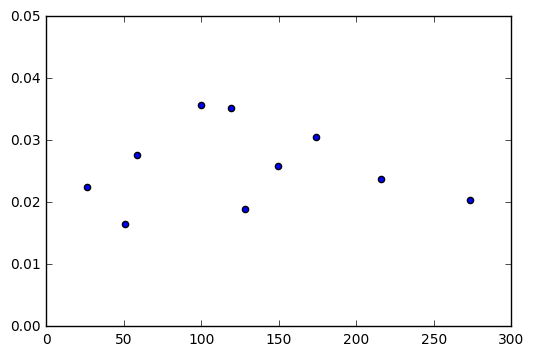

In [6]:
pnts_x = [x for (x,y,_) in points]
pnts_y = [y for (x,y,_) in points]
plt.scatter(pnts_x, pnts_y)

(99.745610951631718, 0.035778106875872136, 'Computers')
(128.44698441701544, 0.019012655494340478, 'Earthquakes')
(58.431313542508839, 0.027695605318829905, 'FordB')
(174.18133638858029, 0.030509040252981356, 'LargeKitchenAppliances')
(149.49149726696942, 0.025838242232298244, 'Phoneme')
(216.22598252194643, 0.023811800395112229, 'RefrigerationDevices')
(119.01919681989166, 0.035161340715677961, 'ScreenType')
(273.39604574257874, 0.02032224486462535, 'SmallKitchenAppliances')
(26.362870404310907, 0.022534815562830223, 'SwedishLeaf')
(50.877418586889036, 0.016585155767489181, 'UWaveGestureLibraryAll')


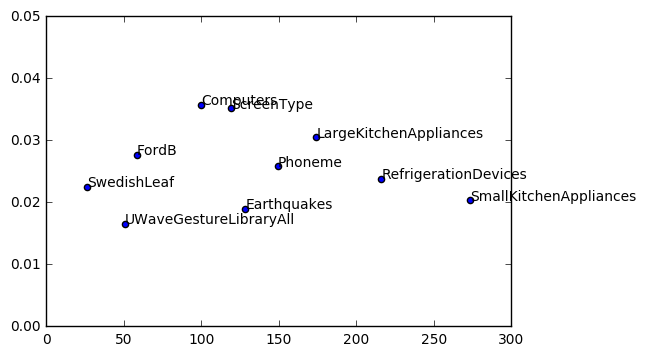

In [7]:
#Let's put some labels
plt.scatter(pnts_x, pnts_y)
for (x,y,l) in points:
#in case you plot more datasets, you can uncomment the next line to see data with large stable rank
# Note: out of most datasets we examined, these ones had relatively large stable rank
#    if x > 50: 
        plt.annotate(l, xy=(x,y))
        print((x,y,l))
plt.show()

Let's see now the effect of Adagio on pairwise distances.

(375, 720)

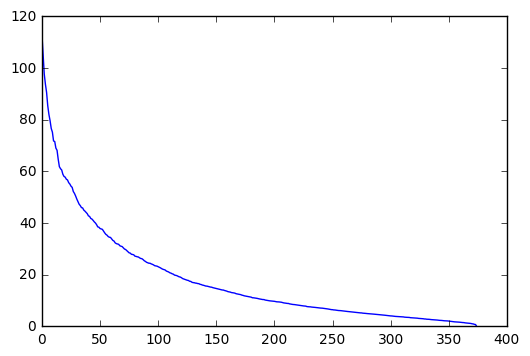

In [8]:
Kitchen = load_UCR("LargeKitchenAppliances")
(stable_rank, fraction_of_mass_left, S) = evaluate_data(Kitchen['train_data'])
plt.plot(S)
(stable_rank, fraction_of_mass_left) 

Kitchen['test_data'].shape
Kitchen['train_data'].shape


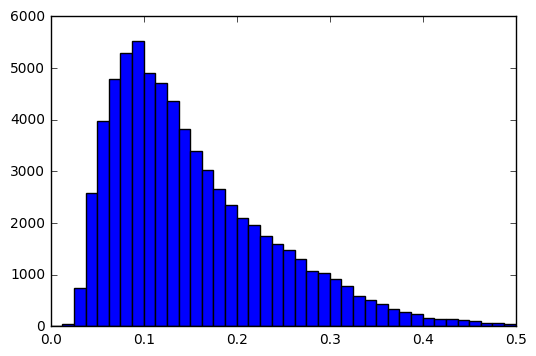

In [9]:
target_dimension = 100
PCA_transformed = {}
reduction = dr.PCAReduction(target_dimension=target_dimension, randomized=False)
PCA_transformed['train'] = reduction.fit_transform(Kitchen['train_data'])
PCA_transformed['test'] = reduction.transform(Kitchen['test_data'])

PCA_train_distortions = dr.all_distortions(Kitchen['train_data'], PCA_transformed['train'])
PCA_test_distortions = dr.all_distortions(Kitchen['test_data'], PCA_transformed['test'])

_ = plt.hist(PCA_test_distortions, bins=40, range=(0, 0.5))

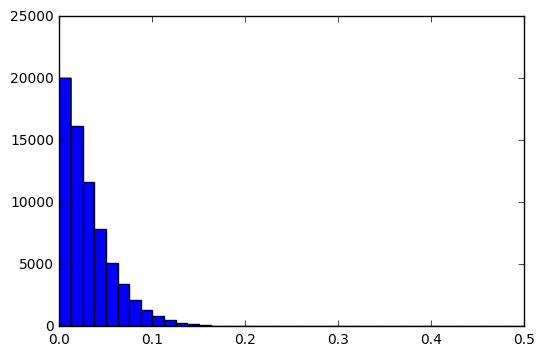

In [10]:
#adagio 
CR_transformed = {}
reduction = dr.BSCompositeReduction(target_dimension=target_dimension)
CR_transformed['train'] = reduction.fit_transform(Kitchen['train_data'])
CR_transformed['test'] = reduction.transform(Kitchen['test_data'])

CR_train_distortions = dr.all_distortions(Kitchen['train_data'], CR_transformed['train'])
CR_test_distortions = dr.all_distortions(Kitchen['test_data'], CR_transformed['test'])
_ = plt.hist(CR_test_distortions, bins=40, range=(0, 0.5))

We see how Adagio for the same target dimension, is able to significantly reduce pairwise distortions, while maintaining its data-awareness (the PCs take into account the structure of the data). 

# Classification using 1NN rule

In [11]:
def classify_point(training_data, training_labels, test_point):
    best_dist = float("inf")
    act_label = -1
    for training_index in range(training_data.shape[0]):
        act_dist = np.linalg.norm(test_point - training_data[training_index, :])
        if act_dist < best_dist:
            best_dist = act_dist
            act_label = training_labels[training_index]
    return act_label

def classify(training_data, training_labels, test_data):
    test_size = test_data.shape[0]
    predicted_labels = np.zeros(test_size).astype(np.int32)
    for test_index in range(test_size):
        predicted_labels[test_index] = classify_point(training_data, training_labels, test_data[test_index, :])
    return predicted_labels 

In [12]:
def accuracy(predicted_labels, actual_labels):
    return (predicted_labels == actual_labels).sum() / predicted_labels.shape[0]

In [13]:
predicted_labels = classify(Kitchen['train_data'], Kitchen['train_labels'], Kitchen['test_data'])
PCA_predicted_labels = classify(PCA_transformed['train'], Kitchen['train_labels'], PCA_transformed['test'])
CR_predicted_labels = classify(CR_transformed['train'], Kitchen['train_labels'], CR_transformed['test'])

In [14]:
accuracy(predicted_labels, Kitchen['test_labels'])

0.49866666666666665

In [15]:
accuracy(PCA_predicted_labels, Kitchen['test_labels'])

0.54133333333333333

In [16]:
accuracy(CR_predicted_labels, Kitchen['test_labels'])

0.48533333333333334

In [17]:
def prepare_distortion_histogram(dataset, reduction):
    transformed = {}
    transformed['train'] = reduction.fit_transform(dataset['train_data'])
    transformed['test'] = reduction.transform(dataset['test_data'])

    train_distortions = dr.all_distortions(dataset['train_data'], transformed['train'])
    test_distortions = dr.all_distortions(dataset['test_data'], transformed['test'])

    _ = plt.hist(test_distortions, bins=80, range=(0, 1))
    plt.show()
    
def analysis_of_dataset(dataset, target_dimension=None):
    (stable_rank, fraction_of_mass_left, S) = evaluate_data(dataset['train_data'])
    if target_dimension is None:
        target_dimension = int(stable_rank)
    print("Spectrum of the dataset:")
    plt.plot(S)
    plt.axvline(x=target_dimension, color="red", linewidth=3) 
    plt.show()
    print("Stable rank:", stable_rank, "Fraction of l_2 mass in tail", fraction_of_mass_left)
    print("Distortion histogram for all pairs of points:")
    print("PCA Reduction: ")
    prepare_distortion_histogram(dataset, dr.PCAReduction(target_dimension=target_dimension, randomized=False))
    print("Our reduction: ")
    prepare_distortion_histogram(dataset, dr.BSCompositeReduction(target_dimension=target_dimension, randomized=False))

Spectrum of the dataset:


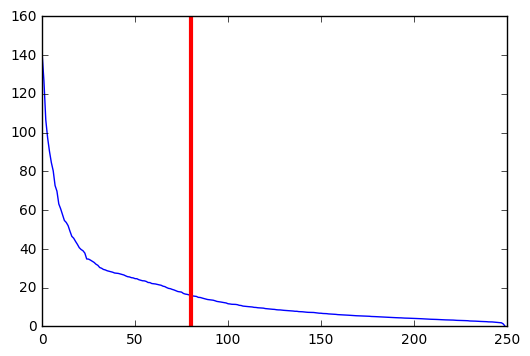

Stable rank: 99.7456109516 Fraction of l_2 mass in tail 0.0357781068759
Distortion histogram for all pairs of points:
PCA Reduction: 


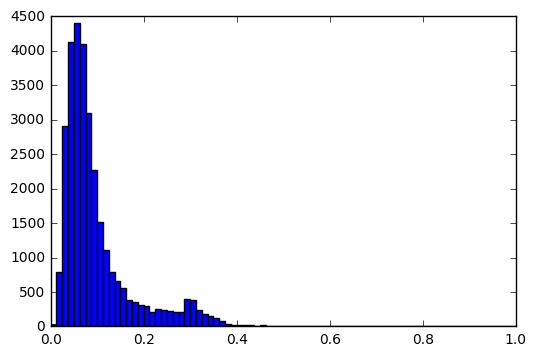

Our reduction: 


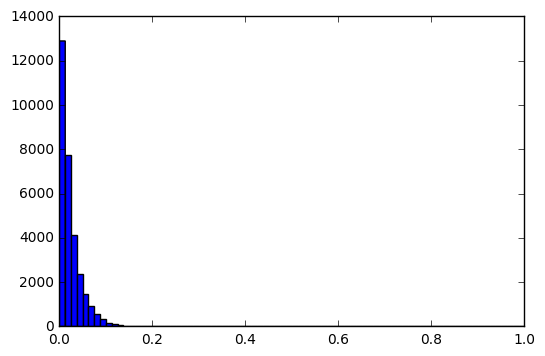

(250, 720)

In [18]:
my_dataset = load_UCR("Computers")
analysis_of_dataset(my_dataset, target_dimension=80)
my_dataset['train_data'].shape

In [19]:
def transformation_accuracy(dataset, reduction):
    train_data = reduction.fit_transform(dataset['train_data'])
    test_data = reduction.transform(dataset['test_data'])
    predicted_labels = classify(train_data, dataset['train_labels'], test_data)
    return accuracy(predicted_labels, dataset['test_labels'])
    
def compare_reductions(dataset, target_dimension = None):
    res = {}
    (stable_rank, fraction_of_mass_left, S) = evaluate_data(dataset['train_data'])
    if target_dimension is None:
        target_dimension = max(30, int(stable_rank)) # XXX <- Magic number. Overfitting?
        target_dimension = min(target_dimension, dataset['train_data'].shape[1])
    res['stable_rank'] = stable_rank
    res['fraction_left'] = fraction_of_mass_left
    res['eigs'] = S
    res['dimension'] = target_dimension
    res['PCA_acc'] = transformation_accuracy(dataset,
                                            dr.PCAReduction(target_dimension=target_dimension,
                                                            randomized=False))
    res['CR_acc'] = transformation_accuracy(dataset,
                                          dr.BSCompositeReduction(target_dimension = target_dimension,
                                                                  randomized=False))
    res['EUC_acc'] = transformation_accuracy(dataset,
                                           dr.NoReduction(target_dimension = target_dimension))
    return res

In [20]:
tmp = []
for td in range(10,380, 10):
    test = compare_reductions(my_dataset, target_dimension=td)
    tmp.append((test['EUC_acc'], test['PCA_acc'], test['CR_acc']))
    print("Done ", td, flush=True)

Done  10
Done  20
Done  30
Done  40
Done  50
Done  60
Done  70
Done  80
Done  90
Done  100
Done  110
Done  120
Done  130
Done  140
Done  150
Done  160
Done  170
Done  180
Done  190
Done  200
Done  210
Done  220
Done  230
Done  240
Done  250
Done  260
Done  270
Done  280
Done  290
Done  300
Done  310
Done  320
Done  330
Done  340
Done  350
Done  360
Done  370


In [21]:
acc_points = []
counter = 0
datasets_stats = []

for dataset_name in all_datasets:
    counter = counter + 1
    print("Doing ", dataset_name, flush = True)
    dataset = load_UCR(dataset_name)
    print("Train size: ", dataset['train_data'].shape, flush = True)
    dataset_stat = compare_reductions(dataset) 
    dataset_stat['name'] = dataset_name
    dataset_stat['train_size'] = dataset['train_data'].shape
    dataset_stat['test_size'] = dataset['test_data'].shape
    print("Stable rank: ", dataset_stat['stable_rank'])
    datasets_stats.append(dataset_stat)
    print("Done ", dataset_name, " ", counter, " out of ", len(all_datasets), flush = True)
    print("=====", flush = True)

Doing  Computers
Train size:  (250, 720)
Stable rank:  99.7456109516
Done  Computers   1  out of  10
=====
Doing  Earthquakes
Train size:  (139, 512)
Stable rank:  128.446984417
Done  Earthquakes   2  out of  10
=====
Doing  FordB
Train size:  (810, 500)
Stable rank:  58.4313135425
Done  FordB   3  out of  10
=====
Doing  LargeKitchenAppliances
Train size:  (375, 720)
Stable rank:  174.181336389
Done  LargeKitchenAppliances   4  out of  10
=====
Doing  Phoneme
Train size:  (214, 1024)
Stable rank:  149.491497267
Done  Phoneme   5  out of  10
=====
Doing  RefrigerationDevices
Train size:  (375, 720)
Stable rank:  216.225982522
Done  RefrigerationDevices   6  out of  10
=====
Doing  ScreenType
Train size:  (375, 720)
Stable rank:  119.01919682
Done  ScreenType   7  out of  10
=====
Doing  SmallKitchenAppliances
Train size:  (375, 720)
Stable rank:  273.396045743
Done  SmallKitchenAppliances   8  out of  10
=====
Doing  SwedishLeaf
Train size:  (500, 128)
Stable rank:  26.3628704043
Done 

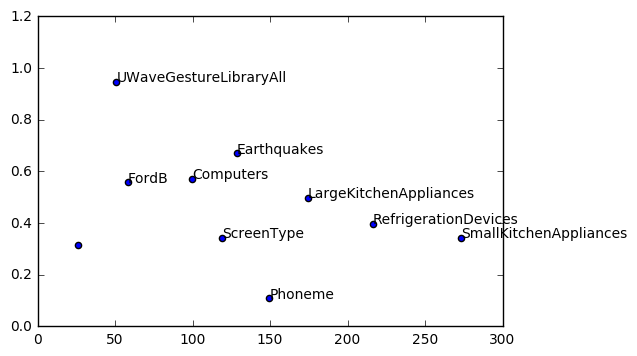

In [22]:
pnts_x = []
pnts_y = []
for dataset in datasets_stats:
    x = dataset['stable_rank']
#    y = min(dataset['test_size'][0], dataset['test_size'][1])
    y = dataset['EUC_acc']
    pnts_x.append(x)
    pnts_y.append(y)
    if dataset['stable_rank'] > 50:
        plt.annotate(dataset['name'], xy=(x,y))

plt.scatter(pnts_x, pnts_y)

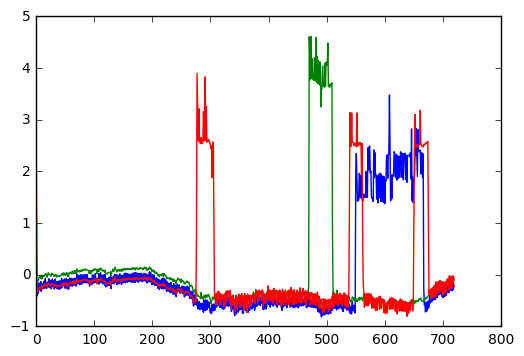

In [23]:
plt.plot(my_dataset['train_data'][11,:])
plt.plot(my_dataset['train_data'][21,:])
plt.plot(my_dataset['train_data'][33,:])

In [48]:
import idx2numpy 
def load_mnist_dataset():
    result = {}
    result['train_data'] = dr.read_mnist("./mnist/train-images-idx3-ubyte")
    with open("./mnist/train-images-idx3-ubyte", 'rb') as f:
        result['train_labels'] = idx2numpy.convert_from_file(f)
    result['test_data'] = dr.read_mnist("./mnist/t10k-images-idx3-ubyte")
    with open("./mnist/t10k-images-idx3-ubyte", 'rb') as f:
        result['test_labels'] = idx2numpy.convert_from_file(f)
    return result

mnist = load_mnist_dataset()

[[[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 ..., 
 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]

 [[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]]


In [51]:
mnist = {}; 
mnist['train_data'] = dr.read_mnist('./mnist/train-images-idx3-ubyte')

In [52]:
mnist['train_data'][:2000,:]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [ ]:
def dimension_from_distortion(data, distortion, randomized = False):
    a = 1;
    b = min(data.shape);
    while b - a > 1:
        x = (a+b)//2;
        red = dr.JLReduction(target_dimension=x);
        redd = red.fit_transform(data);
        dist = max(dr.all_distortions(data, redd));
        if dist > distortion:
            a = x;
        else:
            b = x;
        print("Done step ", x, "dist: ", dist, flush=True)
    return b;

dimension_from_distortion(mnist['train_data'], 0.1)

In [59]:
mnist_subset = mnist['train_data'][:800, :]
mnist_subset.shape
res = []
for target_dimension in range(1, 784, 10):
    reduced = dr.BSCompositeReduction(target_dimension=target_dimension, randomized=False).fit_transform(mnist_subset)
    distortion = max(dr.all_distortions(mnist_subset, reduced))
    res.append((target_dimension, distortion))
    print("Done ", target_dimension, flush=True)



Done  1
Done  11
Done  21
Done  31
Done  41
Done  51
Done  61
Done  71
Done  81
Done  91
Done  101
Done  111
Done  121
Done  131
Done  141
Done  151
Done  161
Done  171
Done  181
Done  191
Done  201
Done  211
Done  221
Done  231
Done  241
Done  251
Done  261
Done  271
Done  281
Done  291
Done  301
Done  311
Done  321
Done  331
Done  341
Done  351
Done  361
Done  371
Done  381
Done  391
Done  401
Done  411
Done  421
Done  431
Done  441
Done  451
Done  461
Done  471
Done  481
Done  491
Done  501
Done  511
Done  521
Done  531
Done  541
Done  551
Done  561
Done  571
Done  581
Done  591
Done  601
Done  611
Done  621
Done  631
Done  641
Done  651
Done  661
Done  671
Done  681
Done  691
Done  701
Done  711
Done  721
Done  731
Done  741
Done  751
Done  761
Done  771
Done  781


In [60]:
tmp = {'train_data': mnist_subset}
randomized_plot = []
for dim in range(10, 500, 20):
    start_time = time.time();
    stats = {'dimension': dim}
    red = dr.BSCompositeReduction(target_dimension=dim, randomized=True)
    stats['rand_adagio_distortion'] = max(dr.all_distortions(mnist_subset, red.fit_transform(mnist_subset)))

    randomized_plot.append(stats)
    total_time = time.time() - start_time;
    print("done dim: ", dim, '  adagio distortion:', stats['rand_adagio_distortion'], 
          'iteration time:', total_time, flush=True)

done dim:  10   adagio distortion: 1.3219489044 iteration time: 5.310549974441528
done dim:  30   adagio distortion: 0.544364943342 iteration time: 5.176144123077393
done dim:  50   adagio distortion: 0.385434609755 iteration time: 5.902696847915649
done dim:  70   adagio distortion: 0.30622708562 iteration time: 5.3030149936676025
done dim:  90   adagio distortion: 0.197240837099 iteration time: 5.496495962142944
done dim:  110   adagio distortion: 0.173483846649 iteration time: 5.427232980728149
done dim:  130   adagio distortion: 0.109139635371 iteration time: 5.322259187698364
done dim:  150   adagio distortion: 0.10051229593 iteration time: 5.466745138168335
done dim:  170   adagio distortion: 0.120026827465 iteration time: 5.84370493888855
done dim:  190   adagio distortion: 0.0903013838164 iteration time: 5.7293291091918945
done dim:  210   adagio distortion: 0.101887159072 iteration time: 6.377024173736572
done dim:  230   adagio distortion: 0.0561195832753 iteration time: 5.48

In [63]:
tmp = {'train_data': mnist_subset}
distortion_plot = []
for dim in range(10, 500, 20):
    start_time = time.time();
    stats = {'dimension': dim}
    red = dr.BSCompositeReduction(target_dimension=dim, randomized=False)
    stats['adagio_distortion'] = max(dr.all_distortions(mnist_subset, red.fit_transform(mnist_subset)))
    
    red = dr.PCAReduction(target_dimension=dim, randomized=False)
    stats['pca_distortion'] = max(dr.all_distortions(mnist_subset, red.fit_transform(mnist_subset)))
    
    red = dr.JLReduction(target_dimension=dim)
    stats['jl_distortion'] = max(dr.all_distortions(mnist_subset, red.fit_transform(mnist_subset)))
    distortion_plot.append(stats)
    total_time = time.time() - start_time;
    print("done dim: ", dim, '  adagio distortion:', stats['adagio_distortion'], 
          '  pca_distortion: ', stats['pca_distortion'], 'iteration time:', total_time, flush=True)

done dim:  10   adagio distortion: 1.32193449023   pca_distortion:  0.866326540709 iteration time: 14.893565893173218
done dim:  30   adagio distortion: 0.743586121074   pca_distortion:  0.644607245922 iteration time: 14.797643899917603
done dim:  50   adagio distortion: 0.349976950555   pca_distortion:  0.554813534021 iteration time: 15.08263897895813
done dim:  70   adagio distortion: 0.267325864547   pca_distortion:  0.45817565918 iteration time: 14.884097814559937
done dim:  90   adagio distortion: 0.196288557653   pca_distortion:  0.411732912064 iteration time: 15.208993911743164
done dim:  110   adagio distortion: 0.175673282301   pca_distortion:  0.378015160561 iteration time: 15.101058006286621
done dim:  130   adagio distortion: 0.142344778228   pca_distortion:  0.334312975407 iteration time: 15.159324884414673
done dim:  150   adagio distortion: 0.123199179036   pca_distortion:  0.283684849739 iteration time: 14.977558135986328
done dim:  170   adagio distortion: 0.0878554110

In [73]:
mnist_numax_res = [
                  {'dimension': 90, 'numax': 0.01},
                  {'dimension': 83, 'numax': 0.05},
                  {'dimension': 59, 'numax': 0.1},
                  {'dimension': 42, 'numax' : 0.2 },
                  {'dimension': 29, 'numax': 0.4},
                  {'dimension': 27, 'numax': 0.7}
                  ]
xn = [];
numax =[];
for item in mnist_numax_res:
    xn.append(item['dimension'])
    numax.append(item['numax'])

x=[]
pca=[]
jl = []
adagio=[]
for item in distortion_plot:
    if (item['dimension'] < 300 and item['dimension'] % 40 == 10) or item['dimension'] % 100 == 10:
        x.append(item['dimension']);
        pca.append(item['pca_distortion'])
        adagio.append(item['adagio_distortion'])
        jl.append(item['jl_distortion'])
    

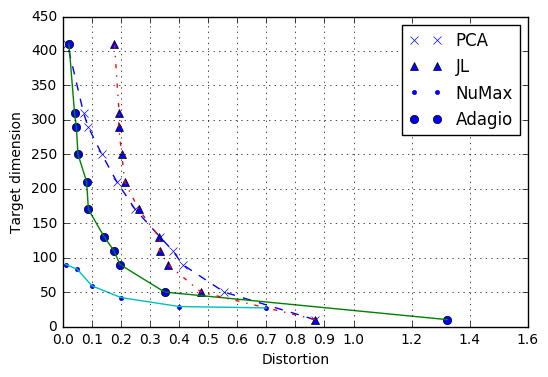

In [74]:
plt.plot(pca, x, 'bx', label='PCA')
plt.plot(jl, x, 'b^', label = 'JL')
plt.plot(numax, xn, 'b.', label='NuMax')
plt.plot(adagio, x, 'bo', label='Adagio')
plt.plot(pca, x, '--', adagio, x, jl, x, '-.', numax, xn)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6])
plt.grid()
plt.legend()
plt.ylabel('Target dimension')
plt.xlabel('Distortion')
plt.savefig('dimension-distortion.png', dpi=200)

In [69]:
adagio_randomized = []
for item in randomized_plot:
    if (item['dimension'] < 300 and item['dimension'] % 40 == 10) or item['dimension'] % 100 == 10:
        adagio_randomized.append(item['rand_adagio_distortion'])
        

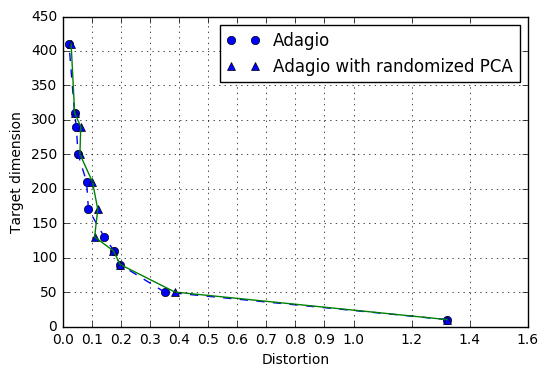

In [70]:
plt.plot(adagio, x, 'bo', label='Adagio')
plt.plot(adagio_randomized, x, 'b^', label='Adagio with randomized PCA')
plt.plot(adagio, x, '--', adagio_randomized, x)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6])
plt.grid()
plt.legend()
plt.ylabel('Target dimension')
plt.xlabel('Distortion')
plt.savefig('adagio-randomized.png', dpi=200)

In [71]:
target_dimension = 100
stats = {}

In [72]:
red = dr.BSCompositeReduction(target_dimension=target_dimension, randomized=False)
stats['adagio_distortion'] = max(dr.all_distortions(mnist_subset, red.fit_transform(mnist_subset)))
    
red = dr.PCAReduction(target_dimension=target_dimension, randomized=False)
stats['pca_distortion'] = max(dr.all_distortions(mnist_subset, red.fit_transform(mnist_subset)))

print(stats)
real_stats = stats;
stats = {}


red = dr.BSCompositeReduction(target_dimension=target_dimension, randomized=False)
stats['adagio_distortion'] = max(dr.all_distortions(mnist_subset, red.fit_transform(mnist_subset), random_sample=100))
    
red = dr.PCAReduction(target_dimension=target_dimension, randomized=False)
stats['pca_distortion'] = max(dr.all_distortions(mnist_subset, red.fit_transform(mnist_subset), random_sample=100))
sample_stats = stats;
print(stats)

{'pca_distortion': 0.3964005708694458, 'adagio_distortion': 0.18506338048542004}
{'pca_distortion': 0.32768476009368896, 'adagio_distortion': 0.16310003740688583}


# Nearest Neigbors for Image Retrieval

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import DimensionalityReduction as dr
import NearestNeighbours as nn
from PIL import Image
from itertools import count
import random
import math
import sys
import scipy as sp
import time
import sklearn
import os
import cv2
import scipy.io
import itertools
from importlib import reload
from collections import Counter
%matplotlib inline

In [3]:
def read_database(files, features_per_img):
    matrices = [];
    cnt = 0
    for i in files:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create(nfeatures = features_per_img)
        _, desc = sift.detectAndCompute(img, None)
        matrices.append(desc)
        cnt = cnt + 1;
        if cnt % 30 == 0:
            print(100*cnt/len(files), flush=True)
    return np.vstack(matrices);

In [4]:
# Download the ZuDuB image database http://www.vision.ee.ethz.ch/showroom_extra/zubud/ZuBuD.tar.gz and add the folder png-ZuBuD in your path
# Download http://www.vision.ee.ethz.ch/showroom_extra/zubud/qimages.tar.gz too
ZuBuD = {}
test_files = ["png-ZuBuD/object" + str(i).zfill(4) +".view01.png" for i in range(1, 202)]
ZuBuD['test_data'] = read_database(test_files, 20)
train_files = ["png-ZuBuD/object" + str(i).zfill(4) + ".view" + str(j).zfill(2) +".png" for (i, j) in itertools.product(range(1, 202), range(2,6))]
ZuBuD['train_data'] = read_database(train_files, 20)

14.925373134328359
29.850746268656717
44.776119402985074
59.701492537313435
74.6268656716418
89.55223880597015
3.7313432835820897
7.462686567164179
11.194029850746269
14.925373134328359
18.65671641791045
22.388059701492537
26.119402985074625
29.850746268656717
33.582089552238806
37.3134328358209
41.04477611940298
44.776119402985074
48.507462686567166
52.23880597014925
55.97014925373134
59.701492537313435
63.43283582089552
67.16417910447761
70.8955223880597
74.6268656716418
78.35820895522389
82.08955223880596
85.82089552238806
89.55223880597015
93.28358208955224
97.01492537313433


In [5]:
print(ZuBuD)

{'train_data': array([[   1.,    1.,    0., ...,    0.,    0.,    0.],
       [   1.,    0.,    0., ...,  115.,    4.,    0.],
       [  29.,   13.,    1., ...,    1.,    1.,    2.],
       ..., 
       [   0.,    0.,   17., ...,    8.,    0.,    0.],
       [   7.,    2.,    1., ...,    0.,    0.,    4.],
       [  33.,   50.,   36., ...,    9.,   94.,    5.]], dtype=float32), 'test_data': array([[  29.,  129.,   28., ...,    0.,    0.,    2.],
       [  43.,    6.,    0., ...,   22.,    0.,    0.],
       [  26.,    0.,    1., ...,    0.,    2.,   42.],
       ..., 
       [   2.,    1.,    1., ...,    0.,    0.,    0.],
       [   0.,    1.,    9., ...,    0.,    0.,    0.],
       [   9.,   17.,    4., ...,    1.,    0.,    0.]], dtype=float32)}


In [6]:
def best_match(database, query, neighbours_per_feature, points_per_object):
    voting = []
    for i in range(query.shape[0]):
        res = nn.find_neighbours(database, query[i], neighbours_per_feature)
        for (_, y) in res:
            voting.append(y//points_per_object)
    return Counter(voting).most_common()

In [7]:
start_time = time.time()
correct = 0
correct_arr = np.zeros(202)
for i in range(202):
    t = best_match(ZuBuD['train_data'], ZuBuD['test_data'][20*i:20*(i+1)], 10, 80)
    if t[0][0] == i:
        correct_arr[i] = 1
        correct = correct + 1
        print("i: ", i, "Correct!", flush=True)     
so_total_time = time.time() - start_time

i:  5 Correct!
i:  10 Correct!
i:  12 Correct!
i:  13 Correct!
i:  14 Correct!
i:  17 Correct!
i:  18 Correct!
i:  20 Correct!
i:  23 Correct!
i:  24 Correct!
i:  25 Correct!
i:  27 Correct!
i:  28 Correct!
i:  29 Correct!
i:  30 Correct!
i:  32 Correct!
i:  33 Correct!
i:  34 Correct!
i:  35 Correct!
i:  38 Correct!
i:  42 Correct!
i:  45 Correct!
i:  46 Correct!
i:  49 Correct!
i:  51 Correct!
i:  53 Correct!
i:  55 Correct!
i:  56 Correct!
i:  58 Correct!
i:  60 Correct!
i:  62 Correct!
i:  66 Correct!
i:  67 Correct!
i:  69 Correct!
i:  70 Correct!
i:  71 Correct!
i:  72 Correct!
i:  73 Correct!
i:  76 Correct!
i:  78 Correct!
i:  79 Correct!
i:  81 Correct!
i:  83 Correct!
i:  84 Correct!
i:  85 Correct!
i:  86 Correct!
i:  88 Correct!
i:  89 Correct!
i:  95 Correct!
i:  97 Correct!
i:  100 Correct!
i:  102 Correct!
i:  104 Correct!
i:  105 Correct!
i:  107 Correct!
i:  118 Correct!
i:  129 Correct!
i:  133 Correct!
i:  134 Correct!
i:  135 Correct!
i:  136 Correct!
i:  137 Correc

In [8]:
so_total_time

211.9916570186615

In [9]:
i=162
best_match(ZuBuD['train_data'], ZuBuD['test_data'][20*i:20*(i+1)], 10, 80)

[(140, 6),
 (163, 6),
 (181, 5),
 (11, 4),
 (17, 4),
 (23, 4),
 (30, 4),
 (72, 4),
 (98, 4),
 (100, 4),
 (104, 4),
 (135, 4),
 (168, 4),
 (7, 3),
 (13, 3),
 (51, 3),
 (96, 3),
 (103, 3),
 (119, 3),
 (128, 3),
 (129, 3),
 (165, 3),
 (176, 3),
 (192, 3),
 (6, 2),
 (25, 2),
 (29, 2),
 (32, 2),
 (33, 2),
 (46, 2),
 (54, 2),
 (64, 2),
 (75, 2),
 (88, 2),
 (93, 2),
 (94, 2),
 (114, 2),
 (137, 2),
 (139, 2),
 (144, 2),
 (146, 2),
 (147, 2),
 (154, 2),
 (161, 2),
 (162, 2),
 (169, 2),
 (173, 2),
 (182, 2),
 (186, 2),
 (202, 2),
 (3, 1),
 (9, 1),
 (10, 1),
 (12, 1),
 (16, 1),
 (19, 1),
 (20, 1),
 (26, 1),
 (28, 1),
 (37, 1),
 (41, 1),
 (44, 1),
 (47, 1),
 (49, 1),
 (50, 1),
 (57, 1),
 (58, 1),
 (69, 1),
 (71, 1),
 (73, 1),
 (74, 1),
 (76, 1),
 (78, 1),
 (80, 1),
 (84, 1),
 (85, 1),
 (90, 1),
 (92, 1),
 (95, 1),
 (97, 1),
 (99, 1),
 (105, 1),
 (109, 1),
 (110, 1),
 (113, 1),
 (115, 1),
 (120, 1),
 (124, 1),
 (126, 1),
 (127, 1),
 (133, 1),
 (141, 1),
 (148, 1),
 (155, 1),
 (156, 1),
 (157, 1),
 

In [10]:
ZuBuD['test_data'].shape

(4085, 128)

In [20]:
adagio = dr.BSCompositeReduction(target_dimension=40, randomized=True)
ZuBuD_adagio =  {}
ZuBuD_adagio['train_data'] = adagio.fit_transform(ZuBuD['train_data'])
ZuBuD_adagio['test_data'] = adagio.transform(ZuBuD['test_data'])

In [22]:
def adagio_get_accuracy(target_dimension):
    start_time = time.time()
    adagio = dr.BSCompositeReduction(target_dimension=target_dimension, randomized=True)
    ZuBuD_adagio =  {}
    ZuBuD_adagio['train_data'] = adagio.fit_transform(ZuBuD['train_data'])
    ZuBuD_adagio['test_data'] = adagio.transform(ZuBuD['test_data'])
    correct = 0
    adagio_correct_arr = np.zeros(202)
    for i in range(202):
        t = best_match(ZuBuD_adagio['train_data'], ZuBuD_adagio['test_data'][20*i:20*(i+1)], 10, 80)
        if t[0][0] ==  i:
            correct = correct + 1
            adagio_correct_arr[i] = 1
            print("i: ", i, "Correct!", flush=True)
    adagio_total_time = time.time() - start_time
    return correct

In [13]:
correct_plot = []
for td in range(10, 51, 10):
    correct = adagio_get_accuracy(td)
    correct_plot.append((td, correct))
    print("Done ",td, " correct: ", correct)

i:  5 Correct!
i:  8 Correct!
i:  9 Correct!
i:  10 Correct!
i:  12 Correct!
i:  13 Correct!
i:  14 Correct!
i:  18 Correct!
i:  19 Correct!
i:  23 Correct!
i:  24 Correct!
i:  25 Correct!
i:  27 Correct!
i:  28 Correct!
i:  29 Correct!
i:  30 Correct!
i:  33 Correct!
i:  38 Correct!
i:  45 Correct!
i:  46 Correct!
i:  48 Correct!
i:  49 Correct!
i:  50 Correct!
i:  55 Correct!
i:  56 Correct!
i:  57 Correct!
i:  60 Correct!
i:  61 Correct!
i:  62 Correct!
i:  63 Correct!
i:  66 Correct!
i:  69 Correct!
i:  70 Correct!
i:  71 Correct!
i:  72 Correct!
i:  73 Correct!
i:  76 Correct!
i:  78 Correct!
i:  79 Correct!
i:  83 Correct!
i:  84 Correct!
i:  86 Correct!
i:  88 Correct!
i:  89 Correct!
i:  95 Correct!
i:  102 Correct!
i:  103 Correct!
i:  107 Correct!
i:  111 Correct!
i:  116 Correct!
i:  118 Correct!
i:  121 Correct!
i:  133 Correct!
i:  134 Correct!
i:  135 Correct!
i:  136 Correct!
i:  137 Correct!
i:  138 Correct!
i:  140 Correct!
i:  141 Correct!
i:  144 Correct!
i:  146 Cor

In [16]:
def best_match(database, query, neighbours_per_feature, points_per_object):
    voting = []
    for i in range(query.shape[0]):
        res = nn.find_neighbours(database, query[i], neighbours_per_feature)
        for (_, y) in res:
            voting.append(y//points_per_object)
    return Counter(voting).most_common()


In [23]:
i=8
adagio = dr.BSCompositeReduction(target_dimension=30, randomized=True)
ZuBuD_adagio =  {}
ZuBuD_adagio['train_data'] = adagio.fit_transform(ZuBuD['train_data'])
ZuBuD_adagio['test_data'] = adagio.transform(ZuBuD['test_data'])
best_match(ZuBuD_adagio['train_data'], ZuBuD_adagio['test_data'][20*i:20*(i+1)], 10, 80)

[(8, 6),
 (126, 6),
 (11, 5),
 (66, 5),
 (69, 5),
 (145, 5),
 (181, 5),
 (44, 4),
 (71, 4),
 (78, 4),
 (137, 4),
 (140, 4),
 (155, 4),
 (7, 3),
 (28, 3),
 (64, 3),
 (73, 3),
 (74, 3),
 (85, 3),
 (89, 3),
 (112, 3),
 (125, 3),
 (153, 3),
 (14, 2),
 (21, 2),
 (26, 2),
 (29, 2),
 (35, 2),
 (41, 2),
 (42, 2),
 (45, 2),
 (46, 2),
 (48, 2),
 (51, 2),
 (56, 2),
 (58, 2),
 (59, 2),
 (76, 2),
 (77, 2),
 (80, 2),
 (98, 2),
 (99, 2),
 (102, 2),
 (111, 2),
 (133, 2),
 (136, 2),
 (138, 2),
 (150, 2),
 (158, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (10, 1),
 (12, 1),
 (15, 1),
 (16, 1),
 (39, 1),
 (40, 1),
 (49, 1),
 (55, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (67, 1),
 (68, 1),
 (72, 1),
 (91, 1),
 (97, 1),
 (101, 1),
 (104, 1),
 (106, 1),
 (113, 1),
 (115, 1),
 (116, 1),
 (119, 1),
 (120, 1),
 (121, 1),
 (122, 1),
 (127, 1),
 (130, 1),
 (131, 1),
 (132, 1),
 (139, 1),
 (141, 1),
 (142, 1),
 (143, 1),
 (146, 1),
 (147, 1),
 (148, 1),
 (149, 1),
 (151, 1),
 (156, 1),
 (159, 1),
 (164, 1),
 (165, 1),
 (1

In [25]:
a = [3,5,7,2,2]
t = Counter(a)

In [27]:
def find_building(dataset, query_number, features_per_img, images_per_building):
    return best_match(dataset['train_data'], 
                      dataset['test_data'][query_number*features_per_img:(query_number+1)*features_per_img],
                      10,
                      features_per_img * images_per_building
                     )

In [28]:
find_building(ZuBuD, 1, 20, 5)

[(0, 9),
 (89, 9),
 (9, 6),
 (83, 6),
 (2, 5),
 (15, 5),
 (67, 5),
 (82, 5),
 (76, 4),
 (100, 4),
 (107, 4),
 (118, 4),
 (158, 4),
 (42, 3),
 (57, 3),
 (85, 3),
 (87, 3),
 (88, 3),
 (90, 3),
 (101, 3),
 (105, 3),
 (106, 3),
 (119, 3),
 (123, 3),
 (134, 3),
 (147, 3),
 (161, 3),
 (6, 2),
 (16, 2),
 (19, 2),
 (20, 2),
 (22, 2),
 (30, 2),
 (43, 2),
 (48, 2),
 (53, 2),
 (56, 2),
 (63, 2),
 (71, 2),
 (86, 2),
 (97, 2),
 (98, 2),
 (99, 2),
 (102, 2),
 (104, 2),
 (116, 2),
 (117, 2),
 (120, 2),
 (138, 2),
 (144, 2),
 (155, 2),
 (1, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (12, 1),
 (14, 1),
 (21, 1),
 (24, 1),
 (27, 1),
 (29, 1),
 (31, 1),
 (34, 1),
 (39, 1),
 (46, 1),
 (52, 1),
 (54, 1),
 (59, 1),
 (64, 1),
 (74, 1),
 (77, 1),
 (81, 1),
 (84, 1),
 (92, 1),
 (95, 1),
 (96, 1),
 (108, 1),
 (113, 1),
 (124, 1),
 (125, 1),
 (126, 1),
 (132, 1),
 (136, 1),
 (140, 1),
 (143, 1),
 (148, 1),
 (149, 1),
 (150, 1),
 (151, 1),
 (160, 1),
 (162, 1)]

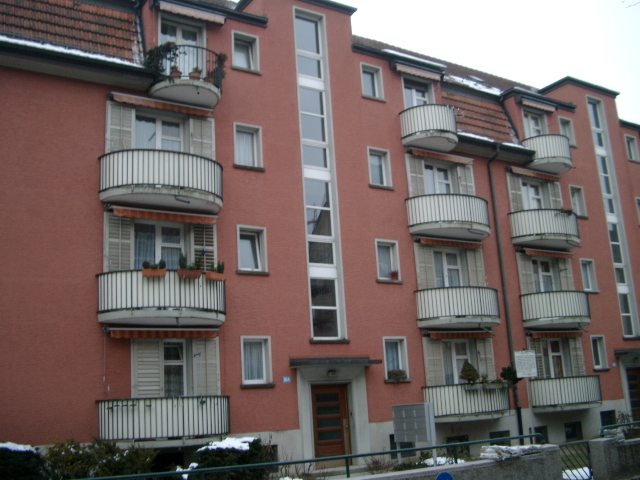

In [32]:
img = Image.Image()
Image.open("png-ZuBuD/object0102.view04.png")

In [35]:
im = cv2.imread("1000city/qimage/qimg0002.JPG")
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(im)

im2 = np.zeros((240, 320), dtype=np.uint8)
ela = cv2.drawKeypoints(im, kp, im2)

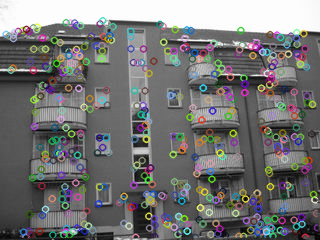

In [36]:
Image.fromarray(ela)

In [37]:
im = cv2.imread("png-ZuBuD/object0009.view03.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create(nfeatures=20)
kp = sift.detect(im)

im2 = np.zeros(im.shape, dtype=np.uint8)
blah = cv2.drawKeypoints(im, kp, im2)

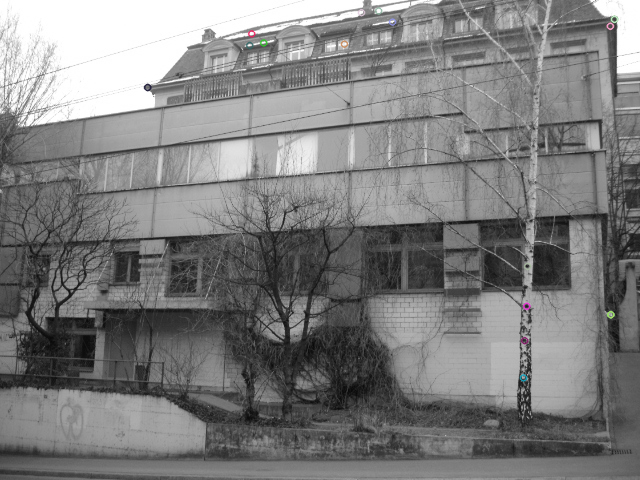

In [38]:
Image.fromarray(blah)

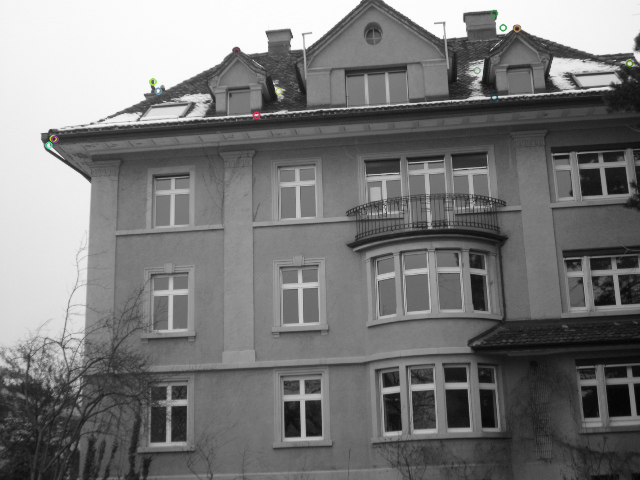

In [41]:
im = cv2.imread("png-ZuBuD/object0126.view03.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create(nfeatures=20)
kp = sift.detect(im)

im2 = np.zeros(im.shape, dtype=np.uint8)
myimage = cv2.drawKeypoints(im, kp, im2)
Image.fromarray(myimage)

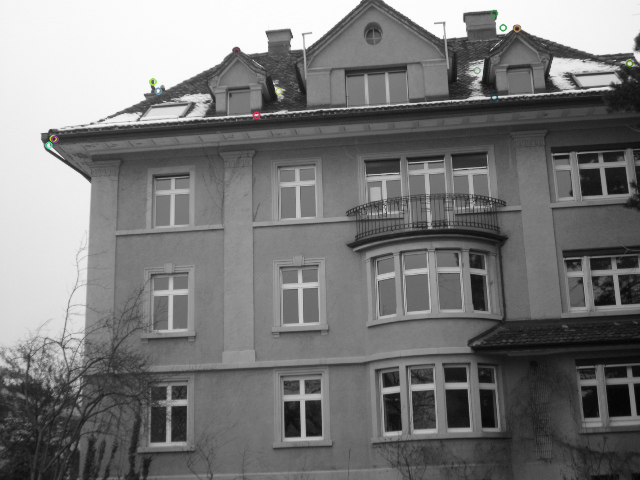

In [42]:
Image.fromarray(myimage)